In [1]:
pip install node2vec



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch-geometric



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
#modeling jo
import numpy as np
import csv
import pandas as pd
pd.set_option('display.max_columns', None)
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import community as nx_community
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from node2vec import Node2Vec
from sklearn.model_selection import RandomizedSearchCV, learning_curve, cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV, train_test_split

In [4]:
from sklearn.preprocessing import StandardScaler

# 2. Charger les données
test_set_final = pd.read_csv("../data/test_set_final.csv", sep=",")
train_set_final = pd.read_csv("../data/train_set_final.csv", sep=",")
node_info = pd.read_csv("../data/node_information.csv", header=None)
test_set = pd.read_csv("../data/test.txt", sep=" ", header=None, names=['source', 'target'])
train_set = pd.read_csv("../data/train.txt", sep=" ", header=None, names=['source', 'target', 'label'])


In [7]:
X_train = train_set.drop('label', axis=1)
y_train = train_set['label']



In [8]:
x_train_val, x_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [9]:
rf = RandomForestClassifier(random_state= 42, criterion = "gini", max_depth= 30, n_estimators= 500)
rf.fit(x_train_val, y_train_val)
y_pred = rf.predict(x_val)
y_pred_train = rf.predict(x_train_val)

print(f"Training Accuracy Random Forest: {accuracy_score(y_train_val, y_pred_train)}")
print(f"Validation Accuracy Random Forest: {accuracy_score(y_val, y_pred)}")


#Training Accuracy Random Forest: 0.8153882801333968
#Validation Accuracy Random Forest: 0.7323809523809524, with everything + max depth 30,est 500

Training Accuracy Random Forest: 0.8138894770273132
Validation Accuracy Random Forest: 0.7238095238095238


Training Accuracy Gradient Boosting: 0.7306
Validation Accuracy Gradient Boosting: 0.7271


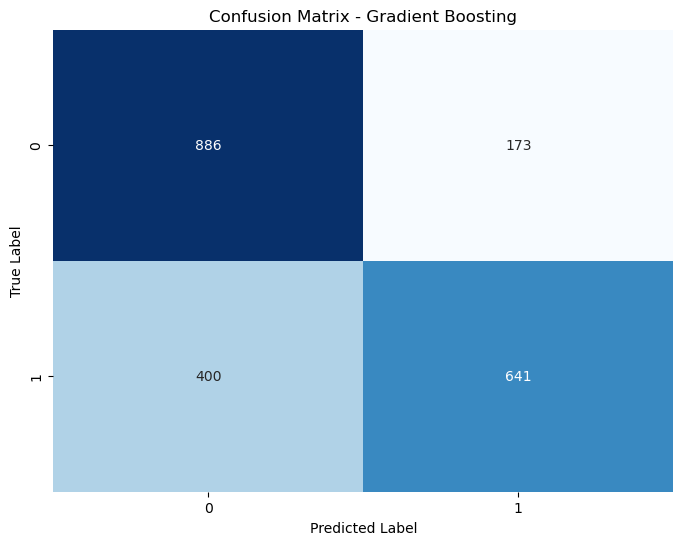

In [118]:
gradient_boosting = GradientBoostingClassifier(random_state=42, learning_rate= 0.05,n_estimators = 300)
gradient_boosting.fit(x_train_val, y_train_val)

# Predict labels on validation set
y_pred = gradient_boosting.predict(x_val)
y_pred_train = gradient_boosting.predict(x_train_val)

# Calculate and print training and validation accuracies
train_accuracy = accuracy_score(y_train_val, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Training Accuracy Gradient Boosting: {train_accuracy:.4f}")
print(f"Validation Accuracy Gradient Boosting: {val_accuracy:.4f}")

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

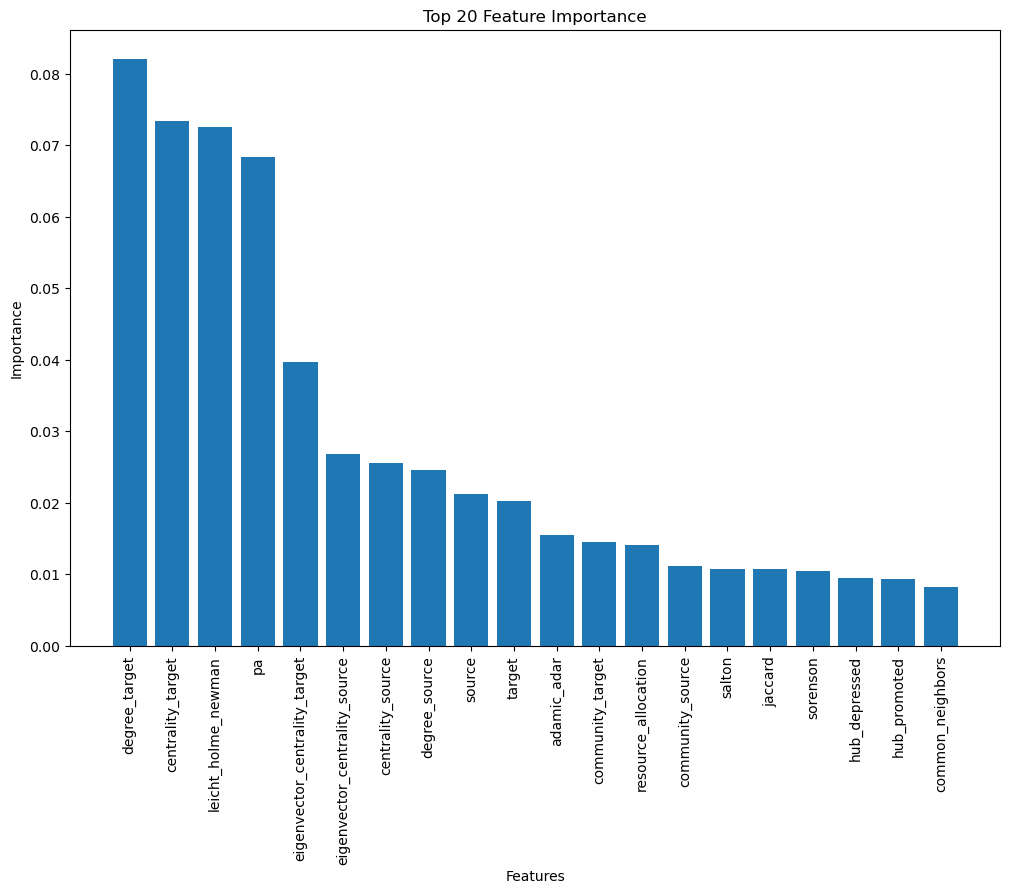

In [33]:
top_features = sorted_importances[:20]
features, importances = zip(*top_features)
plt.figure(figsize=(12, 8))
plt.bar(range(len(top_features)), importances, tick_label=features)
plt.title('Top 20 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

In [ ]:
param_grid = {'n_estimators':np.arange(100,500,50),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [5, 7, 9, 12, 16],
              'max_samples': [0.3, 0.5, 0.8]}

X = train_set.drop('label', axis=1)
y = train_set['label']

rf = RandomForestClassifier(random_state= 42, criterion = "log_loss")

search = RandomizedSearchCV(rf, param_grid, scoring = 'accuracy', n_iter= 30,cv = 4, refit = True)
result = search.fit(X, y)

best_params = result.best_params_
best_score = result.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)

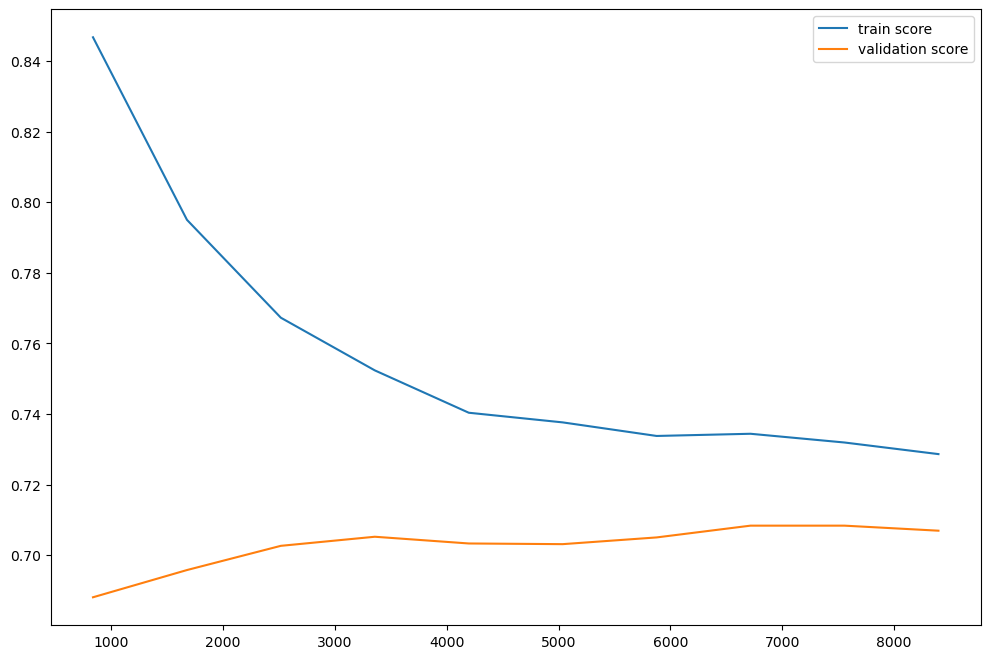

In [30]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

def evaluation(model):

    N, train_score, val_score = learning_curve(model, x_train, y_train,
                                              cv=kfold, scoring='accuracy',
                                               train_sizes=np.linspace(0.1, 1, 10))


    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

evaluation(model)

SUBMISSIONS

In [97]:
test_predictions = rf.predict(test_set)
predictions_df = pd.DataFrame({'ID': test_set.index, 'Predicted': test_predictions})

predictions_df.to_csv('test_predictions.csv', index=False)


In [ ]:
'''
train_graph = nx.Graph()

train_graph.add_nodes_from(map(str, x_train_val['source']))
train_graph.add_nodes_from(map(str, x_train_val['target']))

# Add edges based on y_train_val
for idx, row in x_train_val.iterrows():
    source = str(row['source'])
    target = str(row['target'])
    label = y_train_val.loc[idx]  # Get label based on index
    if label == 1:  # Only add edges for connected nodes
        train_graph.add_edge(source, target)

# Train node2vec model
node2vec = Node2Vec(train_graph, dimensions=64, walk_length=50, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)


unique_nodes = set(X_train['source']).union(set(X_train['target']))
node_embeddings_dict = {}

for idx, node_id in enumerate(unique_nodes):
    if str(node_id) in model.wv:
        node_embeddings_dict[node_id] = model.wv[str(node_id)]
    else:
        # Handle the case where the node is not present in the embeddings
        # For example, you can use zero vectors or some default embedding
        node_embeddings_dict[node_id] = np.zeros(model.vector_size)

# Now you can create feature vectors for each row in X_train
X_train_embed = []

# Iterate over each row in X_train
for idx, row in X_train.iterrows():
    source_node = row['source']
    target_node = row['target']
    
    # Retrieve embeddings for the source and target nodes from the dictionary
    source_embedding = node_embeddings_dict[source_node]
    target_embedding = node_embeddings_dict[target_node]
    
    # Concatenate source and target embeddings to create a feature vector
    feature_vector = np.concatenate((source_embedding, target_embedding))
    
    # Append the feature vector to the list of feature vectors
    X_train_embed.append(feature_vector)

# Convert the list of feature vectors to a numpy array
X_train_embed = np.array(X_train_embed)


# Train logistic regression classifier
clf = LogisticRegression()

clf.fit(x_train_val, y_train_val)
# Predict labels for the validation set
predictions = clf.predict(x_val)
predictions_train = clf.predict(x_train_val)


# Compute accuracy
accuracy = accuracy_score(y_val, predictions)
accuracy_train = accuracy_score(y_train_val, predictions_train)

print(f"Validation Accuracy: {accuracy}")
print(f"Training Accuracy: {accuracy_train}")'''